In [1]:
from bq_helper import BigQueryHelper
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
chicago_crime = BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="chicago_crime")

In [3]:
# creating bigquery object
bq_assistant = BigQueryHelper("bigquery-public-data", "chicago_crime")
bq_assistant.list_tables()

['crime']

In [4]:
bq_assistant.head("crime", num_rows=3)

,unique_key,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,beat,district,ward,community_area,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location
0,2467886,HH797387,2002-11-23 12:20:00+00:00,052XX S PULASKI RD,0915,MOTOR VEHICLE THEFT,"TRUCK, BUS, MOTOR HOME",PARKING LOT/GARAGE(NON.RESID.),False,False,815,8,23,62,07,None,None,2002,2015-08-17 15:03:40+00:00,None,None,None
1,7678320,HS482956,2003-02-02 00:00:00+00:00,048XX S KEDVALE AVE,0266,CRIM SEXUAL ASSAULT,PREDATORY,APARTMENT,False,True,815,8,23,57,02,None,None,2003,2015-08-17 15:03:40+00:00,None,None,None
2,10715781,HZ473795,2014-06-05 12:00:00+00:00,033XX W 114TH ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,2211,22,19,74,11,None,None,2014,2016-10-15 15:46:46+00:00,None,None,None


In [5]:
bq_assistant.table_schema("crime")

,name,type,mode,description
0,unique_key,INTEGER,REQUIRED,Unique identifier for the record.
1,case_number,STRING,NULLABLE,The Chicago Police Department RD Number (Recor...
2,date,TIMESTAMP,NULLABLE,Date when the incident occurred. this is somet...
3,block,STRING,NULLABLE,The partially redacted address where the incid...
4,iucr,STRING,NULLABLE,The Illinois Unifrom Crime Reporting code. Thi...
5,primary_type,STRING,NULLABLE,The primary description of the IUCR code.
6,description,STRING,NULLABLE,"The secondary description of the IUCR code, a ..."
7,location_description,STRING,NULLABLE,Description of the location where the incident...
8,arrest,BOOLEAN,NULLABLE,Indicates whether an arrest was made.
9,domestic,BOOLEAN,NULLABLE,Indicates whether the incident was domestic-re...


Let's look if the number of crimes increases of declines over the years.

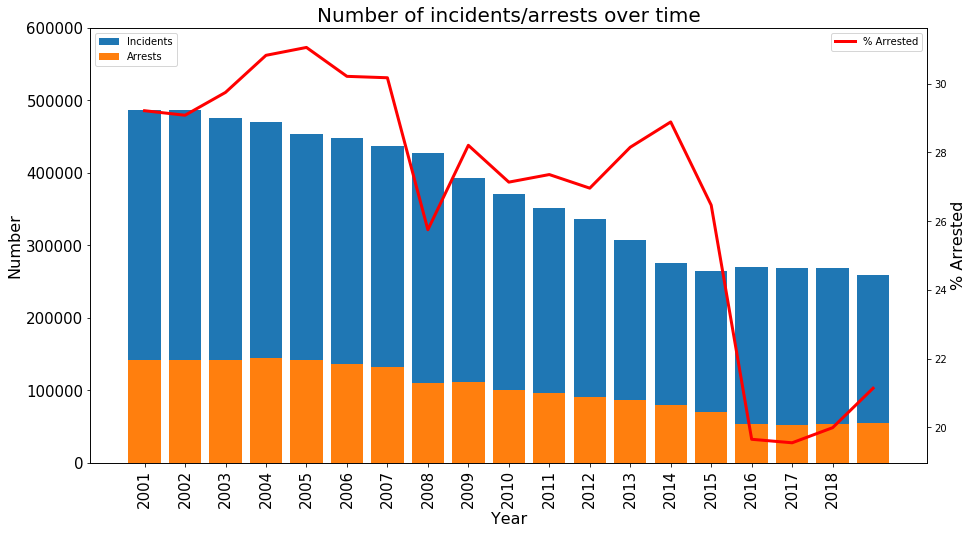

In [7]:
query1 = '''
SELECT
    year,
    COUNT(1) AS incidents,
    COUNTIF(arrest = True) AS arrests,
    COUNTIF(arrest = True)/COUNT(1) * 100 AS pct_of_arrests
FROM `bigquery-public-data.chicago_crime.crime`
WHERE year < 2020
GROUP BY year
ORDER BY year
'''

crimes_overall = bq_assistant.query_to_pandas_safe(query1, max_gb_scanned=0.5)

# Set a plot figure
fig, ax1 = plt.subplots(figsize=(15, 8))

plt.xlabel('Year', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Number of incidents/arrests over time', fontsize=20)

# set a bar graph
ax1.bar(x=crimes_overall.year, height=crimes_overall.incidents, label='Incidents')
ax1.bar(x=crimes_overall.year, height=crimes_overall.arrests, label='Arrests')

plt.yticks(np.arange(0, 700000, 100000), fontsize=15)
plt.xticks(np.arange(min(crimes_overall.year), max(crimes_overall.year), 1),
          rotation='vertical', fontsize=15)
ax1.legend(loc=2)

# set a line graph which will share the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('% Arrested', fontsize=16)
ax2.plot(crimes_overall.year, crimes_overall.pct_of_arrests, label='% Arrested', 
         color='red', linewidth=3)
ax2.legend(loc=0)

plt.show()

The first observation is that the number  of incidents and arrests has been declining over time. Also the percentage of arrests declined sharply between year 2015 and 2016.

What are the most popular types of crime?

In [21]:
query2 = '''
SELECT 
    primary_type,
    COUNT(1) AS incidents,
    COUNTIF(arrest = True) AS arrests,
    COUNTIF(arrest = True)/COUNT(1) * 100 AS pct_of_arrests
FROM `bigquery-public-data.chicago_crime.crime`
GROUP BY primary_type
ORDER BY arrests DESC
'''

popular_crimes = bq_assistant.query_to_pandas_safe(query2, max_gb_scanned=0.5)
popular_crimes.head(10)

,primary_type,incidents,arrests,pct_of_arrests
0,NARCOTICS,728607,724352,99.416009
1,BATTERY,1291406,293321,22.713306
2,THEFT,1494091,177007,11.847136
3,CRIMINAL TRESPASS,201625,146206,72.513825
4,ASSAULT,443160,101237,22.844345
5,OTHER OFFENSE,439003,79202,18.041335
6,PROSTITUTION,69133,68866,99.613788
7,WEAPONS VIOLATION,78195,61278,78.365624
8,CRIMINAL DAMAGE,803402,56466,7.028362
9,DECEPTIVE PRACTICE,286934,45236,15.765298


Let's see the visualization of the quantity of the most popular incidents and arrests.

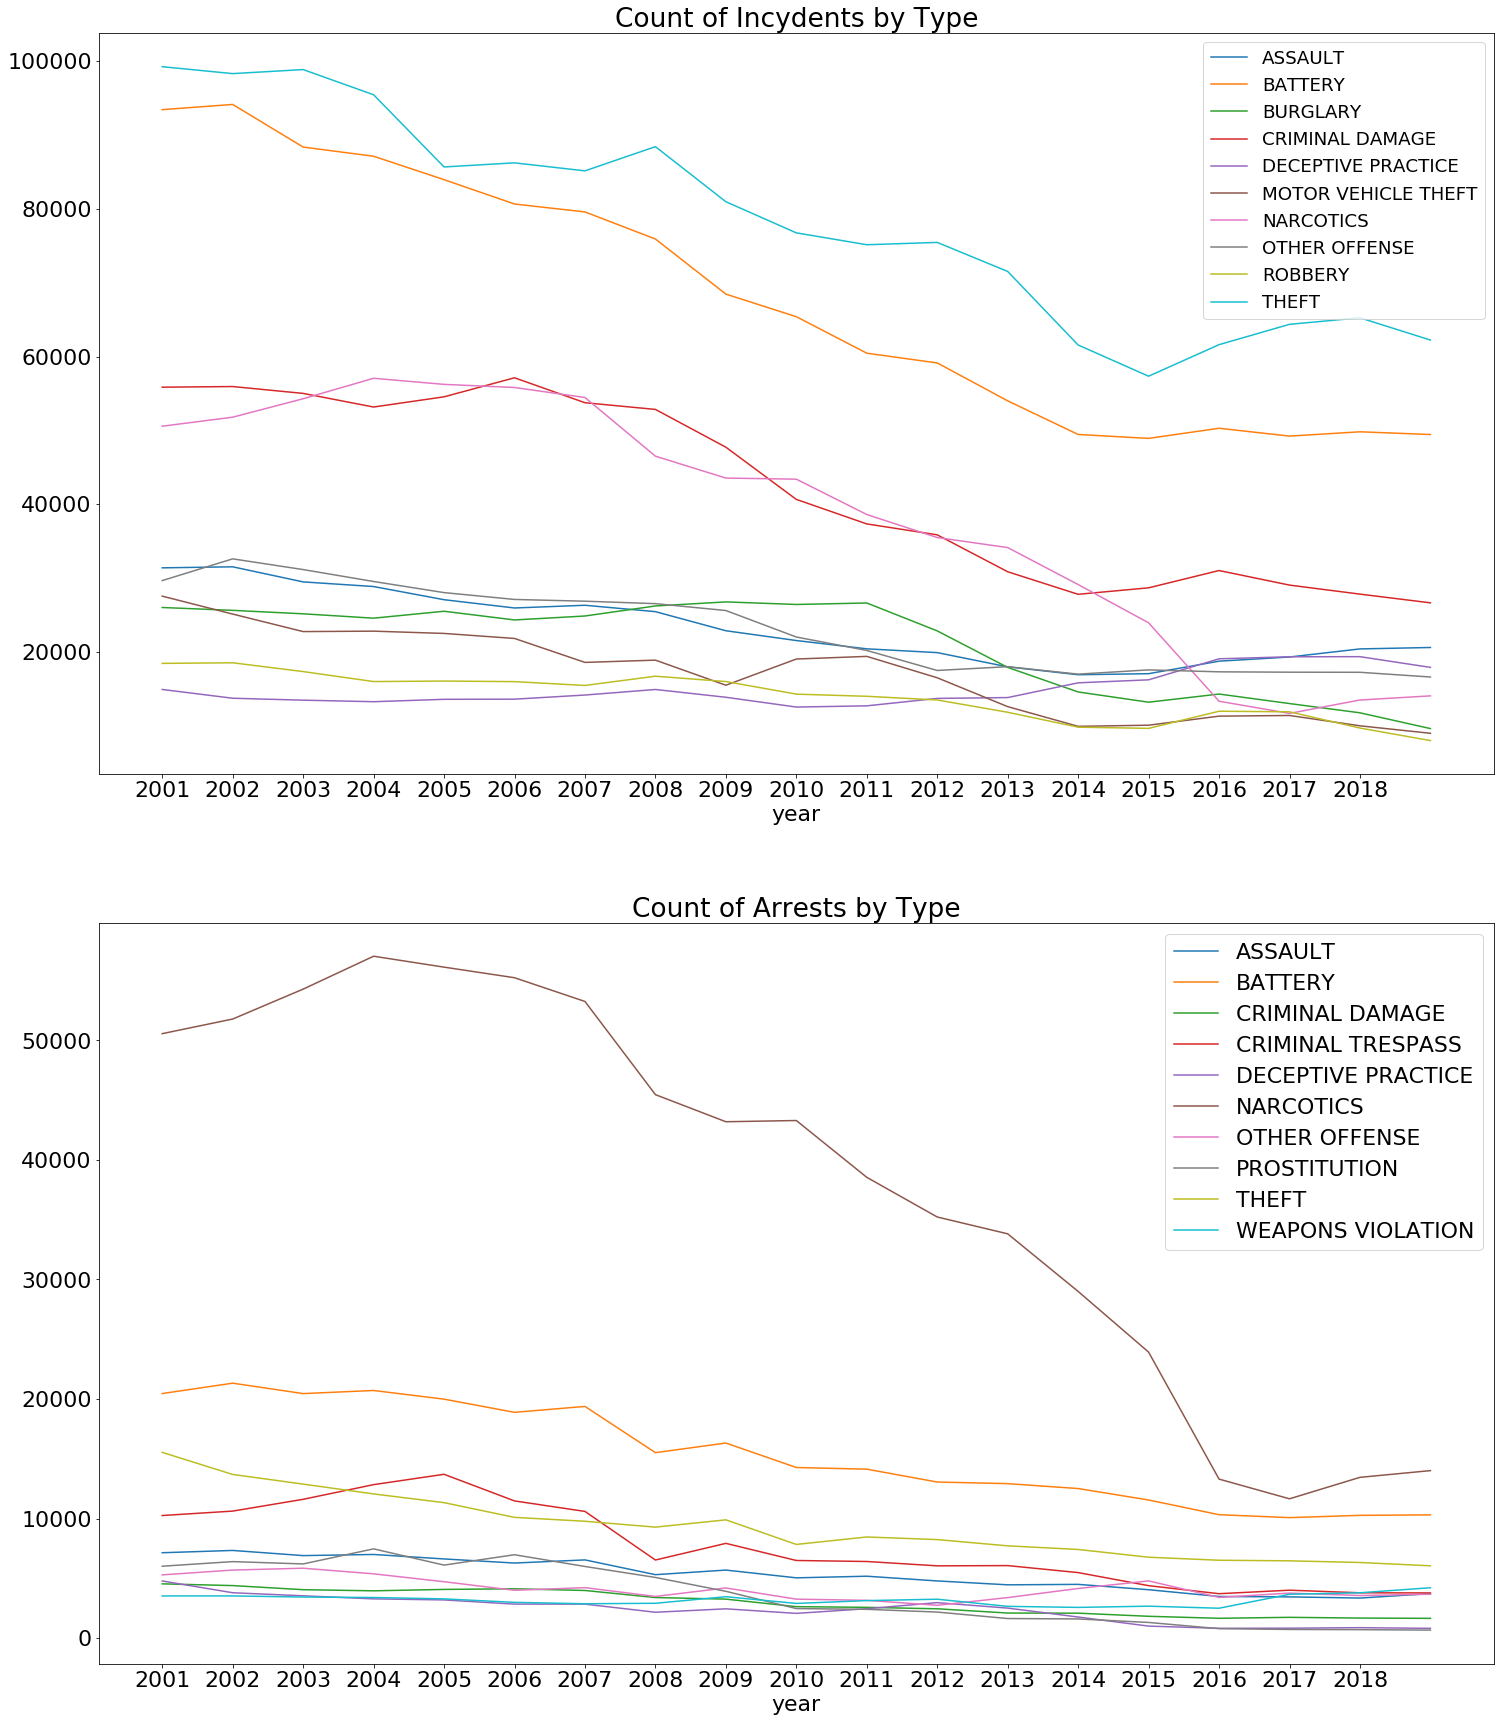

In [53]:
query3 = '''
SELECT 
    primary_type,
    year,
    COUNT(1) AS incidents,
    COUNTIF(arrest = True) AS arrests,
FROM `bigquery-public-data.chicago_crime.crime`
WHERE year < 2020
GROUP BY primary_type, year
ORDER BY year
'''

result3 = bq_assistant.query_to_pandas_safe(query3, max_gb_scanned=0.5)
popular_incidents = ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 'ASSAULT', 
                     'OTHER OFFENSE', 'BURGLARY', 'MOTOR VEHICLE THEFT', 
                     'DECEPTIVE PRACTICE', 'ROBBERY']

popular_arrests = ['NARCOTICS', 'BATTERY', 'THEFT', 'CRIMINAL TRESPASS', 'ASSAULT',
                   'OTHER OFFENSE', 'PROSTITUTION', 'WEAPONS VIOLATION', 'CRIMINAL DAMAGE',
                   'DECEPTIVE PRACTICE']

incidents_df = result3[result3.primary_type.isin(popular_incidents)]
arrests_df = result3[result3.primary_type.isin(popular_arrests)]

# set up the size and fonts
plt.rcParams['font.size'] = 22
fig = plt.figure(figsize = (25, 30))

# first plot showing the most popular incidents
ax1 = fig.add_subplot(211)
ax1.set_title('Count of Incydents by Type')
plt.xticks(np.arange(min(result3.year), max(result3.year), step=1))
#plt.yticks(np.arange(0, 150000, 20000))
for name, group in incidents_df.groupby('primary_type'):
    group.plot(x='year', y='incidents', ax=ax1, label=name)
ax1.legend(loc=0, fontsize='small')

# second plot showing the most popular accidents
ax2 = fig.add_subplot(212)
ax2.set_title('Count of Arrests by Type')
plt.xticks(np.arange(min(result3.year), max(result3.year), step=1))
for name, group in arrests_df.groupby('primary_type'):
    group.plot(x='year', y='arrests', ax=ax2, label=name)
ax1.legend(loc=0, fontsize='small')

What types of crime exhibited the greatest increase between 2015 and 2016?


In [54]:
query2 = '''
SELECT
  primary_type,
  description,
  COUNTIF(year = 2015) AS arrests_2015,
  COUNTIF(year = 2016) AS arrests_2016,
  FORMAT('%3.2f', (COUNTIF(year = 2016) - COUNTIF(year = 2015)) / COUNTIF(year = 2015)*100) AS pct_change_2015_to_2016
FROM
  `bigquery-public-data.chicago_crime.crime`
WHERE
  arrest = TRUE
  AND year IN (2015,
    2016)
GROUP BY
  primary_type,
  description
HAVING
  COUNTIF(year = 2015) > 100
ORDER BY
  (COUNTIF(year = 2016) - COUNTIF(year = 2015)) / COUNTIF(year = 2015) DESC
        '''

response1 = chicago_crime.query_to_pandas_safe(query1, max_gb_scanned=0.5)
response1.head(10)

,primary_type,incidents,arrests,pct_of_arrests
0,THEFT,1494091,177007,11.847136
1,BATTERY,1291406,293321,22.713306
2,CRIMINAL DAMAGE,803402,56466,7.028362
3,NARCOTICS,728607,724352,99.416009
4,ASSAULT,443160,101237,22.844345
5,OTHER OFFENSE,439003,79202,18.041335
6,BURGLARY,399921,22940,5.736133
7,MOTOR VEHICLE THEFT,325236,29325,9.016530
8,DECEPTIVE PRACTICE,286934,45236,15.765298
9,ROBBERY,265665,25663,9.659910


Which month generally has the greatest number of motor vehicle thefts?


In [58]:
# select months with the most crimes committed before the year 2017:
query2  = '''
        SELECT year,
        month,
        nr_of_motor_vehicle_theft
        FROM(        
            SELECT EXTRACT(MONTH FROM date) as month,
                year,
                COUNT(1) as nr_of_motor_vehicle_theft,
                RANK() OVER (PARTITION BY year ORDER BY COUNT(1) DESC) AS ranking
            FROM `bigquery-public-data.chicago_crime.crime`
            WHERE primary_type = 'MOTOR VEHICLE THEFT'
                AND year < 2017
            GROUP BY month, year)        
        WHERE ranking = 1
        ORDER BY year DESC
'''

result2 = bq_assistant.query_to_pandas_safe(query2, max_gb_scanned=0.5)
result2.head(10)

,year,month,nr_of_motor_vehicle_theft
0,2016,12,1110
1,2015,8,968
2,2014,10,922
3,2013,1,1470
4,2012,6,1469
5,2011,1,1862
6,2010,12,1880
7,2009,12,1539
8,2008,7,2015
9,2007,10,1709
